### Handling imports from pandas, numpy, basemap & sklearn

In [1]:
#Set charts to view inline;(directive '%')
%matplotlib inline
import numpy as np
import pandas as pd

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


import geopandas
import shapely.geometry


from sklearn import preprocessing as prep
from datetime import datetime

import warnings
##suppress all warnings
warnings.filterwarnings("ignore")

#### Index by CaseNumber  && Cleaning 'DeathLoc' coordinates 

In [2]:
ADRD = 'Accidental_Drug_Related_Deaths__2012-2017.csv'
ORTA ='Opioid_Related_Treatment_Admissions_by_Town_in_Department_of_Mental_Health_and_Addiction_Services_Programs.csv'
df = pd.read_csv(ADRD, index_col='CaseNumber',parse_dates=['Date'])
#list comprehension:
df['DeathLoc'] = [i.split("\n") for i in df['DeathLoc']]
df['DeathLoc'] =[i[1].strip('()').split(',') for i in df['DeathLoc']]
df.head()

Date     Sex   Race   Age Residence City Residence State  \
CaseNumber                                                                  
13-16336   2013-11-09  Female  White  53.0         GROTON             NaN   
12-18447   2012-12-29    Male  White  30.0        WOLCOTT             NaN   
14-2758    2014-02-18    Male  White  43.0        ENFIELD             NaN   
14-13497   2014-09-07  Female  White  24.0    WALLINGFORD             NaN   
13-14421   2013-10-04  Female  White  26.0     WEST HAVEN             NaN   

           Residence County   Death City Death State Death County  \
CaseNumber                                                          
13-16336         NEW LONDON       GROTON         NaN   NEW LONDON   
12-18447          NEW HAVEN    WATERBURY         NaN    NEW HAVEN   
14-2758                 NaN      ENFIELD         NaN          NaN   
14-13497                NaN  WALLINGFORD         NaN    NEW HAVEN   
13-14421          NEW HAVEN   WEST HAVEN         NaN    NEW HAVEN   

                      ...            Benzodiazepine Methadone Amphet Tramad  \
CaseNumber            ...                                                     
13-16336              ...                         Y       NaN    NaN    NaN   
12-18447              ...                       NaN       NaN    NaN    NaN   
14-2758               ...                         Y       NaN    NaN    NaN   
14-13497              ...                       NaN       NaN    NaN    NaN   
13-14421              ...                       NaN       NaN    NaN    NaN   

           Morphine (not heroin) Other Any Opioid MannerofDeath  \
CaseNumber                                                        
13-16336                     NaN   NaN        NaN      Accident   
12-18447                     NaN   NaN        NaN      Accident   
14-2758                      NaN   NaN        NaN      Accident   
14-13497                     NaN   NaN        NaN      Accident   
13-14421                     NaN   NaN        NaN      Accident   

           AmendedMannerofDeath                  DeathLoc  
CaseNumber                                                 
13-16336                    NaN   [41.343693,  -72.07877]  
12-18447                    NaN  [41.554261,  -73.043069]  
14-2758                     NaN  [41.976501,  -72.591985]  
14-13497                    NaN  [41.454408,  -72.818414]  
13-14421                    NaN  [41.272336,  -72.949817]  

[5 rows x 31 columns]

<br><br>
#### Cleaning and mapping data

In [3]:
df.dtypes

Date                     datetime64[ns]
Sex                              object
Race                             object
Age                             float64
Residence City                   object
Residence State                  object
Residence County                 object
Death City                       object
Death State                      object
Death County                     object
Location                         object
DescriptionofInjury              object
InjuryPlace                      object
ImmediateCauseA                  object
Heroin                           object
Cocaine                          object
Fentanyl                         object
Oxycodone                        object
Oxymorphone                      object
EtOH                             object
Hydrocodone                      object
Benzodiazepine                   object
Methadone                        object
Amphet                           object
Tramad                           object


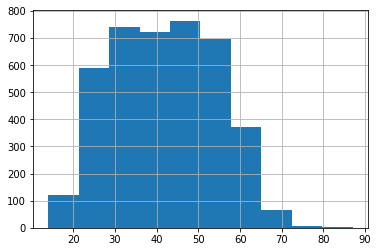

In [4]:
df['Age'].hist()
#skewed right:
df['Age'].fillna(df['Age'].median(), inplace = True)

In [5]:
df['Age'].median()

42.0

In [6]:
drugList = [
'Heroin',
'Cocaine',              
'Fentanyl',               
'EtOH',                     
'Benzodiazepine',           
]


df['Gender_Dummy'] = df.Sex.map({'Male': 0, 'Female': 1})

# an issue arrised with fillna(0) producing a value that was seen to the mapper as NaN.
# solution: fillna('N') and assign back to column. mapping works properly.
for drug in drugList:
    print(drug)
    df[drug] = df[drug].fillna('N')
    df[drug + "_Mapped"] = pd.Series(df[drug]).map({'Y': 1, 'y': 1, 'N': 0, np.nan: 0})



Heroin
Cocaine
Fentanyl
EtOH
Benzodiazepine


In [7]:
#df[['Heroin_Mapped','Heroin', 'Cocaine', 'Fentanyl', 'Oxycodone', 'Oxymorphone', 'EtOH',
#       'Hydrocodone', 'Benzodiazepine', 'Methadone']].head()
# df.keys()

 I mapped the np.nan values above to 0 but there are still three null values in Heroin

In [8]:
df.groupby('Cocaine').agg('count')

Date   Sex  Race   Age  Residence City  Residence State  \
Cocaine                                                            
N        2907  2905  2901  2908            2847             1530   
Y        1167  1167  1164  1168            1120              609   
y           5     5     5     5               3                3   

         Residence County  Death City  Death State  Death County  \
Cocaine                                                            
N                    2375        2906         1564          2097   
Y                     979        1166          631           797   
y                       3           5            5             5   

                 ...            Any Opioid  MannerofDeath  \
Cocaine          ...                                        
N                ...                   567           2904   
Y                ...                   146           1165   
y                ...                     0              5   

         AmendedMannerofDeath  DeathLoc  Gender_Dummy  Heroin_Mapped  \
Cocaine                                                                
N                         367      2908          2905           2906   
Y                         171      1168          1167           1167   
y                           0         5             5              5   

         Cocaine_Mapped  Fentanyl_Mapped  EtOH_Mapped  Benzodiazepine_Mapped  
Cocaine                                                                       
N                  2908             2905         2898                   2908  
Y                  1168             1167         1160                   1168  
y                     5                5            5                      5  

[3 rows x 36 columns]

In [9]:
df.Heroin.isnull().sum()

0

<br><br>
### Building a Matrices for Race

In [10]:
df.groupby(['Sex']).agg('count')

Date  Race   Age  Residence City  Residence State  Residence County  \
Sex                                                                           
Female  1086  1081  1086            1062              549               882   
Male    2990  2987  2991            2906             1592              2473   

        Death City  Death State  Death County  Location  \
Sex                                                       
Female        1086          559           770      1082   
Male          2989         1640          2128      2975   

                ...            Any Opioid  MannerofDeath  \
Sex             ...                                        
Female          ...                   175           1086   
Male            ...                   538           2984   

        AmendedMannerofDeath  DeathLoc  Gender_Dummy  Heroin_Mapped  \
Sex                                                                   
Female                   144      1086          1086           1086   
Male                     394      2991          2991           2988   

        Cocaine_Mapped  Fentanyl_Mapped  EtOH_Mapped  Benzodiazepine_Mapped  
Sex                                                                          
Female            1086             1084         1081                   1086  
Male              2991             2989         2978                   2991  

[2 rows x 36 columns]

### Cleaning up column headers (", ")

In [11]:
race_dummies = pd.get_dummies(df.Race, prefix='race')
## list comprehension to replace column headers with space and comma
race_dummies.columns = [col.replace(', ', '_') for col in race_dummies.columns]
race_dummies.head()

race_Asian Indian  race_Asian_Other  race_Black  race_Chinese  \
CaseNumber                                                                  
13-16336                    0                 0           0             0   
12-18447                    0                 0           0             0   
14-2758                     0                 0           0             0   
14-13497                    0                 0           0             0   
13-14421                    0                 0           0             0   

            race_Hawaiian  race_Hispanic_Black  race_Hispanic_White  \
CaseNumber                                                            
13-16336                0                    0                    0   
12-18447                0                    0                    0   
14-2758                 0                    0                    0   
14-13497                0                    0                    0   
13-14421                0                    0                    0   

            race_Native American_Other  race_Other  race_Unknown  race_White  
CaseNumber                                                                    
13-16336                             0           0             0           1  
12-18447                             0           0             0           1  
14-2758                              0           0             0           1  
14-13497                             0           0             0           1  
13-14421                             0           0             0           1

In [12]:
# concatenate the dummy variable columns onto the DataFrame (axis=0 means rows, axis=1 means columns)
df = pd.concat([df, race_dummies], axis=1)
df.head()

Date     Sex   Race   Age Residence City Residence State  \
CaseNumber                                                                  
13-16336   2013-11-09  Female  White  53.0         GROTON             NaN   
12-18447   2012-12-29    Male  White  30.0        WOLCOTT             NaN   
14-2758    2014-02-18    Male  White  43.0        ENFIELD             NaN   
14-13497   2014-09-07  Female  White  24.0    WALLINGFORD             NaN   
13-14421   2013-10-04  Female  White  26.0     WEST HAVEN             NaN   

           Residence County   Death City Death State Death County    ...      \
CaseNumber                                                           ...       
13-16336         NEW LONDON       GROTON         NaN   NEW LONDON    ...       
12-18447          NEW HAVEN    WATERBURY         NaN    NEW HAVEN    ...       
14-2758                 NaN      ENFIELD         NaN          NaN    ...       
14-13497                NaN  WALLINGFORD         NaN    NEW HAVEN    ...       
13-14421          NEW HAVEN   WEST HAVEN         NaN    NEW HAVEN    ...       

           race_Asian_Other race_Black race_Chinese race_Hawaiian  \
CaseNumber                                                          
13-16336                  0          0            0             0   
12-18447                  0          0            0             0   
14-2758                   0          0            0             0   
14-13497                  0          0            0             0   
13-14421                  0          0            0             0   

           race_Hispanic_Black race_Hispanic_White race_Native American_Other  \
CaseNumber                                                                      
13-16336                     0                   0                          0   
12-18447                     0                   0                          0   
14-2758                      0                   0                          0   
14-13497                     0                   0                          0   
13-14421                     0                   0                          0   

           race_Other race_Unknown race_White  
CaseNumber                                     
13-16336            0            0          1  
12-18447            0            0          1  
14-2758             0            0          1  
14-13497            0            0          1  
13-14421            0            0          1  

[5 rows x 48 columns]

In [13]:
df.keys()

Index(['Date', 'Sex', 'Race', 'Age', 'Residence City', 'Residence State',
       'Residence County', 'Death City', 'Death State', 'Death County',
       'Location', 'DescriptionofInjury', 'InjuryPlace', 'ImmediateCauseA',
       'Heroin', 'Cocaine', 'Fentanyl', 'Oxycodone', 'Oxymorphone', 'EtOH',
       'Hydrocodone', 'Benzodiazepine', 'Methadone', 'Amphet', 'Tramad',
       'Morphine (not heroin)', 'Other', 'Any Opioid', 'MannerofDeath',
       'AmendedMannerofDeath', 'DeathLoc', 'Gender_Dummy', 'Heroin_Mapped',
       'Cocaine_Mapped', 'Fentanyl_Mapped', 'EtOH_Mapped',
       'Benzodiazepine_Mapped', 'race_Asian Indian', 'race_Asian_Other',
       'race_Black', 'race_Chinese', 'race_Hawaiian', 'race_Hispanic_Black',
       'race_Hispanic_White', 'race_Native American_Other', 'race_Other',
       'race_Unknown', 'race_White'],
      dtype='object')

In [14]:
df['race_Asian Indian'].shape

(4081,)

In [15]:
dfRace = pd.DataFrame(data = df[['race_Asian Indian', 'race_Asian_Other', 'race_Black',
     'race_Chinese', 'race_Hawaiian', 'race_Hispanic_Black',
       'race_Hispanic_White', 'race_Native American_Other', 'race_Other',
       'race_Unknown', 'race_White']].sum()/4081*100, columns = ['percent'],index = None )



In [16]:
dfRace = dfRace.reset_index()

In [17]:
dfRace.keys()

Index(['index', 'percent'], dtype='object')

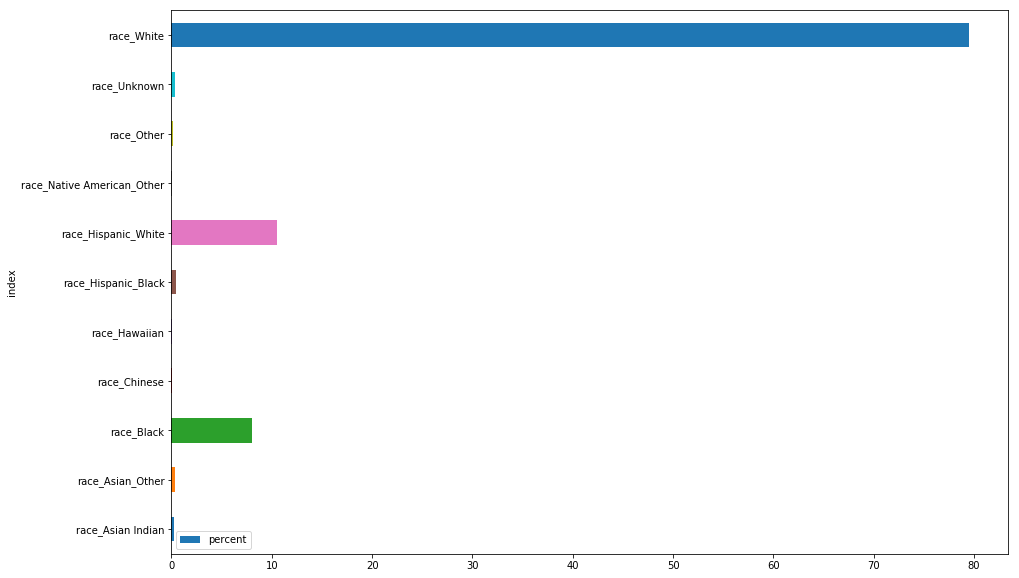

In [18]:
dfRace.plot(x='index', y='percent', kind="barh", figsize=(15,10))

<br><br>
## Correlations:

In [19]:
df['Fentanyl_Mapped'] = df.Fentanyl_Mapped.fillna(0)

In [20]:
df.Fentanyl_Mapped.isnull().sum()

0

In [21]:
df.corr()

Age  Gender_Dummy  Heroin_Mapped  \
Age                         1.000000      0.037957      -0.166655   
Gender_Dummy                0.037957      1.000000      -0.120655   
Heroin_Mapped              -0.166655     -0.120655       1.000000   
Cocaine_Mapped              0.046642     -0.028428       0.001979   
Fentanyl_Mapped            -0.117941     -0.095061      -0.007777   
EtOH_Mapped                 0.076050     -0.053271      -0.035802   
Benzodiazepine_Mapped       0.039246      0.092213      -0.137380   
race_Asian Indian          -0.030474     -0.004698       0.002807   
race_Asian_Other           -0.031869      0.021538       0.013765   
race_Black                  0.120545     -0.003334      -0.077487   
race_Chinese               -0.031933      0.011708       0.021038   
race_Hawaiian               0.020642     -0.009438      -0.016490   
race_Hispanic_Black        -0.006160     -0.004549       0.000475   
race_Hispanic_White         0.026403     -0.065592       0.038261   
race_Native American_Other  0.002846     -0.009438      -0.016490   
race_Other                 -0.015063     -0.011588      -0.008070   
race_Unknown               -0.012156     -0.020074       0.012475   
race_White                 -0.092200      0.051106       0.021949   

                            Cocaine_Mapped  Fentanyl_Mapped  EtOH_Mapped  \
Age                               0.046642        -0.117941     0.076050   
Gender_Dummy                     -0.028428        -0.095061    -0.053271   
Heroin_Mapped                     0.001979        -0.007777    -0.035802   
Cocaine_Mapped                    1.000000         0.013953    -0.036144   
Fentanyl_Mapped                   0.013953         1.000000    -0.020319   
EtOH_Mapped                      -0.036144        -0.020319     1.000000   
Benzodiazepine_Mapped            -0.145591        -0.053128    -0.007644   
race_Asian Indian                -0.006774         0.030298    -0.000474   
race_Asian_Other                 -0.009483        -0.000075    -0.011742   
race_Black                        0.171903        -0.027605     0.021004   
race_Chinese                     -0.014063        -0.016527    -0.012007   
race_Hawaiian                    -0.009943        -0.011685    -0.008489   
race_Hispanic_Black              -0.007451         0.039035     0.022320   
race_Hispanic_White               0.061868         0.021303    -0.022139   
race_Native American_Other       -0.009943        -0.011685    -0.008489   
race_Other                        0.012928        -0.006230     0.020064   
race_Unknown                     -0.005189         0.010437     0.003541   
race_White                       -0.159684        -0.004051    -0.001020   

                            Benzodiazepine_Mapped  race_Asian Indian  \
Age                                      0.039246          -0.030474   
Gender_Dummy                             0.092213          -0.004698   
Heroin_Mapped                           -0.137380           0.002807   
Cocaine_Mapped                          -0.145591          -0.006774   
Fentanyl_Mapped                         -0.053128           0.030298   
EtOH_Mapped                             -0.007644          -0.000474   
Benzodiazepine_Mapped                    1.000000          -0.027298   
race_Asian Indian                       -0.027298           1.000000   
race_Asian_Other                         0.004536          -0.002758   
race_Black                              -0.097325          -0.013921   
race_Chinese                             0.012639          -0.001041   
race_Hawaiian                            0.026962          -0.000736   
race_Hispanic_Black                     -0.020032          -0.003041   
race_Hispanic_White                     -0.083859          -0.016155   
race_Native American_Other              -0.009090          -0.000736   
race_Other                               0.003204          -0.001949   
race_Unknown                            -0.018369   

In [22]:
# In this example, we will try to predict the value of Apple stock at stock market closing
# using the value of it's highest cost during a given day.  In other words, we will try 
# to predict the value of 'close' using the value of 'high'
# To put this in machine learning / data mining terms, 'close' is our response variable and 
# 'high' our predictor variable
X = df[['Fentanyl_Mapped', 'Age']]
y = df[['race_Hispanic_White']]

### Split Data - Training data - train_test_split

In [23]:
# Split Data
# Now we can split our data into a training and test set.  In this example, we are using an 80/20 split, 
# where 80% of our data will be used for training our model, and 20% of our data will be used for testing.
    
from sklearn.model_selection import train_test_split

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1) # test size 20%, random = True

### Training Model 
fit - learning a model
X_train, Y_train = 80% of data

In [24]:
# Train Model
# Now we train our LinearRegression model using the training subset of data.

from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
# Now that our model is trained, we can view the coefficients of the model using regression_model.coef_, 
# which is an array of tuples of coefficients.
# Each regression coefficient shows the strength of the relationship between the predictor variable and the
# outcome variable while controlling for the other predictor variable 

for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for Fentanyl_Mapped is 0.016524459007916756
The coefficient for Age is 0.0008158320245424961


In [26]:
# regression_model.intercept_ returns an array of intercepts
intercept = regression_model.intercept_[0]

print("The intercept for our model is {}".format(intercept))

The intercept for our model is 0.06602000762723241


Now that we know the regression coefficient for our predictor variable and the intercept, we can figure out our model:

ŷ = 0.2680893 + 0.29794x


y = 0.2680893 + 0.29794()<br>
Predicted= 000<br>
Acutal =  000

In [27]:
regression_model.score(X_test, y_test)

0.00019777349148475398

# Task: 

<ul>
<li>Join housing data with Death based on town as PK</li>
<li>Deaths per town to predict the next town to experince a death related opiods(Regression)</li>

<br>
<li>anamiated map of accidental drug deaths 2012, 2013,.., 2017</li>
<li>anamiated map of treamment drug 2012, 2013,.., 2017    any coorelations between the two.</li>


## Resample the coordinates base on year to year

In [28]:
year2012 = df.loc[(df['Date'].dt.year==2012)]
year2013 = df.loc[(df['Date'].dt.year==2013)]
year2014 = df.loc[(df['Date'].dt.year==2014)]
year2015 = df.loc[(df['Date'].dt.year==2015)]
year2016 = df.loc[(df['Date'].dt.year==2016)]
year2017 = df.loc[(df['Date'].dt.year==2017)]

#### Creating a map object of Connecticut with county lines

In [29]:
def dot_Density_Maps(upperRightLAT,upperRightLONG,lowerLeftLAT,lowerLeftLONG, layerData1 = True ,layerData2 = True ):
    #http://basemaptutorial.readthedocs.io/en/latest/backgrounds.html

    map = Basemap(urcrnrlat=upperRightLAT,     # upper right - lat
                  urcrnrlon=upperRightLONG,   # upper right - long
                  llcrnrlat=lowerLeftLAT,     # lower left - lat
                  llcrnrlon=lowerLeftLONG,   # lower left - long
                  epsg=3857)

    #An EPSG code is used to specify a coordinate reference system,
    #which in layman's terms is just a way to turn points on the surface
    #of the earth into x and y coordinates for use in a map. 
    #So, for our purposes, they can be considered the same thing as 
    #a map projection, and I'll be using the term projection from here on out to represent both.

    # These are the dimensions of the map we'll create
    width = 20
    height = 10

    fig = plt.gcf()
    fig.set_size_inches(width, height);

    # The default DPI setting is 96, we're just specifying it here 
    # to use it for calculating the number of x-axis pixels to request.
    dpi = 96
    xpixels = dpi * width


    map.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=xpixels)
    map.drawcounties()
    x,y = map([float(y[1]) for y in df['DeathLoc']], [float(x[0]) for x in df['DeathLoc']])
#     xB,yB = map(lonB,latB)
    

    #http://basemaptutorial.readthedocs.io/en/latest/plotting_data.html#scatter
    # https://matplotlib.org/api/markers_api.html
    if(layerData1):
        map.scatter(x, y, c='r', alpha=0.02, marker='o', s=50, linewidths=0)
    if(layerData2):
        map.scatter(xB, yB, c='b', alpha=0.02, marker='D', s=50, linewidths=0)

    plt.title("Drug Related Deaths 2012 - 2017")
    plt.show()
    


In [30]:
# extract_Lat_Long(df2['TownGeo'],lonB,latB)
dot_Density_Maps(42.068779,-71.752764,40.954090,-73.779741,layerData2=False)

## correlation between:

## using the each years data to represent deaths: education(y) - income(x) - size (death)

# 1. education - dropout
# 2. income
# 3. 


In [31]:
df.dtypes

Date                          datetime64[ns]
Sex                                   object
Race                                  object
Age                                  float64
Residence City                        object
Residence State                       object
Residence County                      object
Death City                            object
Death State                           object
Death County                          object
Location                              object
DescriptionofInjury                   object
InjuryPlace                           object
ImmediateCauseA                       object
Heroin                                object
Cocaine                               object
Fentanyl                              object
Oxycodone                             object
Oxymorphone                           object
EtOH                                  object
Hydrocodone                           object
Benzodiazepine                        object
Methadone 

forcasting drug use from income[education, poverty, happiness,...] and current drug trends

# GEO_PANDAS

In [32]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

df['Lon'] = [float(y[1]) for y in df['DeathLoc']]
df['Lat'] = [float(x[0]) for x in df['DeathLoc']]


geometry = [Point(xy) for xy in zip(df.Lon, df.Lat)]
df = df.drop(['Lon', 'Lat'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(df, crs=crs, geometry=geometry)

In [33]:
gdf.head()

Date     Sex   Race   Age Residence City Residence State  \
CaseNumber                                                                  
13-16336   2013-11-09  Female  White  53.0         GROTON             NaN   
12-18447   2012-12-29    Male  White  30.0        WOLCOTT             NaN   
14-2758    2014-02-18    Male  White  43.0        ENFIELD             NaN   
14-13497   2014-09-07  Female  White  24.0    WALLINGFORD             NaN   
13-14421   2013-10-04  Female  White  26.0     WEST HAVEN             NaN   

           Residence County   Death City Death State Death County  \
CaseNumber                                                          
13-16336         NEW LONDON       GROTON         NaN   NEW LONDON   
12-18447          NEW HAVEN    WATERBURY         NaN    NEW HAVEN   
14-2758                 NaN      ENFIELD         NaN          NaN   
14-13497                NaN  WALLINGFORD         NaN    NEW HAVEN   
13-14421          NEW HAVEN   WEST HAVEN         NaN    NEW HAVEN   

                            ...                  race_Black race_Chinese  \
CaseNumber                  ...                                            
13-16336                    ...                           0            0   
12-18447                    ...                           0            0   
14-2758                     ...                           0            0   
14-13497                    ...                           0            0   
13-14421                    ...                           0            0   

           race_Hawaiian race_Hispanic_Black race_Hispanic_White  \
CaseNumber                                                         
13-16336               0                   0                   0   
12-18447               0                   0                   0   
14-2758                0                   0                   0   
14-13497               0                   0                   0   
13-14421               0                   0                   0   

           race_Native American_Other race_Other race_Unknown race_White  \
CaseNumber                                                                 
13-16336                            0          0            0          1   
12-18447                            0          0            0          1   
14-2758                             0          0            0          1   
14-13497                            0          0            0          1   
13-14421                            0          0            0          1   

                                        geometry  
CaseNumber                                        
13-16336    POINT (-72.07877000000001 41.343693)  
12-18447            POINT (-73.043069 41.554261)  
14-2758     POINT (-72.59198499999999 41.976501)  
14-13497            POINT (-72.818414 41.454408)  
13-14421            POINT (-72.949817 41.272336)  

[5 rows x 49 columns]

In [34]:
townShape = geopandas.read_file("polygons.geojson")

map2 = geopandas.read_file("polygons.geojson")

In [35]:
townShape.keys()

Index(['Town', 'Pop2000', 'Pop2010', 'PctChgPop', 'geometry'], dtype='object')

In [36]:
townShape.head()

Town  Pop2000  Pop2010  PctChgPop  \
0      Bethel    18067    18584   0.028616   
1  Bridgeport   139529   144229   0.033685   
2  Brookfield    15664    16452   0.050306   
3     Danbury    74848    80893   0.080764   
4      Darien    19607    20732   0.057377   

                                            geometry  
0  POLYGON ((-73.40596614845322 41.42820239971312...  
1  POLYGON ((-73.24416908442974 41.22660036572057...  
2  POLYGON ((-73.42694315732838 41.46384240594386...  
3  POLYGON ((-73.40596614845322 41.42820239971312...  
4  POLYGON ((-73.50075716096971 41.11442233537724...

In [37]:
ax = map2.plot(column = 'Pop2010', categorical = True, 
                    figsize = (10,10),legend = True,)

# Spatial Joins
GeoPandas includes functionality to performspatial joins and overlay(sjoin and overlay).
here, let's do a spatial join to determin the quariter in which each death is located.

In [39]:
townShape = geopandas.sjoin(gdf,townShape [['Town','geometry']].copy(),op='intersects')

In [40]:
townShape.head()

Date     Sex   Race   Age Residence City Residence State  \
13-16336 2013-11-09  Female  White  53.0         GROTON             NaN   
Dec-91   2012-04-22  Female  White  51.0         GROTON             NaN   
15-5318  2015-03-25    Male  White  35.0         GROTON              CT   
15-2211  2015-02-04    Male  White  59.0         GROTON              CT   
14-18364 2014-12-08  Female  White  51.0         GROTON             NaN   

         Residence County Death City Death State Death County   ...    \
13-16336       NEW LONDON     GROTON         NaN   NEW LONDON   ...     
Dec-91         NEW LONDON     GROTON         NaN   NEW LONDON   ...     
15-5318        NEW LONDON     GROTON          CT   NEW LONDON   ...     
15-2211        NEW LONDON     GROTON          CT   NEW LONDON   ...     
14-18364              NaN     GROTON         NaN   NEW LONDON   ...     

         race_Hawaiian race_Hispanic_Black race_Hispanic_White  \
13-16336             0                   0                   0   
Dec-91               0                   0                   0   
15-5318              0                   0                   0   
15-2211              0                   0                   0   
14-18364             0                   0                   0   

         race_Native American_Other race_Other race_Unknown race_White  \
13-16336                          0          0            0          1   
Dec-91                            0          0            0          1   
15-5318                           0          0            0          1   
15-2211                           0          0            0          1   
14-18364                          0          0            0          1   

                                      geometry index_right    Town  
13-16336  POINT (-72.07877000000001 41.343693)          28  Groton  
Dec-91    POINT (-72.07877000000001 41.343693)          28  Groton  
15-5318   POINT (-72.07877000000001 41.343693)          28  Groton  
15-2211   POINT (-72.07877000000001 41.343693)          28  Groton  
14-18364  POINT (-72.07877000000001 41.343693)          28  Groton  

[5 rows x 51 columns]

In [41]:
townShape.keys()

Index(['Date', 'Sex', 'Race', 'Age', 'Residence City', 'Residence State',
       'Residence County', 'Death City', 'Death State', 'Death County',
       'Location', 'DescriptionofInjury', 'InjuryPlace', 'ImmediateCauseA',
       'Heroin', 'Cocaine', 'Fentanyl', 'Oxycodone', 'Oxymorphone', 'EtOH',
       'Hydrocodone', 'Benzodiazepine', 'Methadone', 'Amphet', 'Tramad',
       'Morphine (not heroin)', 'Other', 'Any Opioid', 'MannerofDeath',
       'AmendedMannerofDeath', 'DeathLoc', 'Gender_Dummy', 'Heroin_Mapped',
       'Cocaine_Mapped', 'Fentanyl_Mapped', 'EtOH_Mapped',
       'Benzodiazepine_Mapped', 'race_Asian Indian', 'race_Asian_Other',
       'race_Black', 'race_Chinese', 'race_Hawaiian', 'race_Hispanic_Black',
       'race_Hispanic_White', 'race_Native American_Other', 'race_Other',
       'race_Unknown', 'race_White', 'geometry', 'index_right', 'Town'],
      dtype='object')

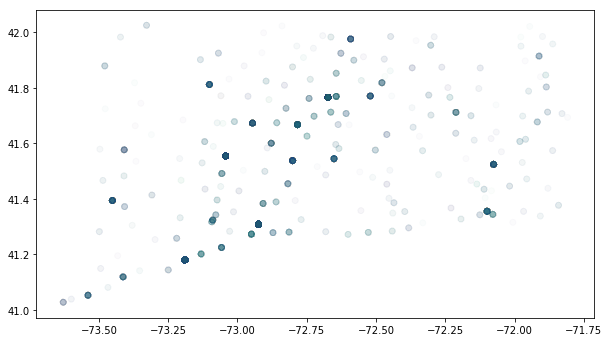

In [42]:
townShape.plot(column = 'Age', figsize = (10,10),alpha=0.02)

In [43]:
counts = townShape.groupby('Death City').size()

In [44]:

gdf.plot(markersize=counts,
         alpha=0.2, scheme='quantiles',ax = map2.plot(figsize = (16,10),edgecolor='white', color='lightgrey') ) 





In [45]:
townShape = townShape.merge(counts.reset_index(name = "number_of_deaths"))

In [46]:
ax = townShape.plot(ax =map2.plot(figsize = (16,10),edgecolor='white',
                              color='lightgrey'), column = 'number_of_deaths', categorical = True , cmap = 'tab20',
                    figsize = (10,10),edgecolor='white' )
ax.set_axis_off()

In [47]:
townShape.plot(column = 'number_of_deaths')

### Resampled the data based on Month

In [48]:
# drugList = [              
# 'Cocaine',              
# 'Fentanyl',               
# 'Oxycodone',                 
# # 'Oxymorphone',               
# # 'EtOH',                     
# # 'Hydrocodone',              
# # 'Benzodiazepine',           
# # 'Methadone',                 
# # 'Amphet',                    
# # 'Tramad'
# ]


dfYears = df.resample('M',on='Date').agg({'Heroin_Mapped':'sum'})
for x in drugList:
    dfYears[x] = df.resample('M',on='Date').agg({x+"_Mapped":'sum'})
dfYears.head()

Heroin_Mapped  Heroin  Cocaine  Fentanyl  EtOH  Benzodiazepine
Date                                                                      
2012-01-31           14.0    14.0        8       0.0   8.0               4
2012-02-29           10.0    10.0        8       1.0   6.0               3
2012-03-31            7.0     7.0        4       1.0   2.0               6
2012-04-30           17.0    17.0       17       1.0   7.0               5
2012-05-31           13.0    13.0       10       1.0   4.0               2

## Total count based on City [County?]

In [49]:
drug_mapped = df.keys()[33:37]

In [50]:
# df['Death City'] = [row.upper() for row in df['Death City']]

In [51]:
dfCity = pd.DataFrame(index=df['Death City'])
for drug in drug_mapped:
    dfCity[drug]=df.groupby('Death City').agg({drug: 'sum'})

In [52]:
dfCity.head(30)

Cocaine_Mapped  Fentanyl_Mapped  EtOH_Mapped  \
Death City                                                   
GROTON                   5.0              5.0          9.0   
WATERBURY               87.0             65.0         56.0   
ENFIELD                 21.0             21.0         14.0   
WALLINGFORD              8.0              6.0         11.0   
WEST HAVEN              17.0             12.0         11.0   
DANBURY                 22.0             23.0         21.0   
BRIDGEPORT              85.0             80.0         63.0   
NEW HAVEN               84.0             64.0         55.0   
DANBURY                 22.0             23.0         21.0   
WATERBURY               87.0             65.0         56.0   
BRIDGEPORT              85.0             80.0         63.0   
WINDSOR                  7.0              6.0          7.0   
NEW HARTFORD             1.0              1.0          0.0   
HARTFORD               132.0            142.0         71.0   
DANBURY                 22.0             23.0         21.0   
MANCHESTER              19.0             27.0         14.0   
HARTFORD               132.0            142.0         71.0   
WATERBURY               87.0             65.0         56.0   
NAUGATUCK                8.0              9.0          6.0   
NEW HAVEN               84.0             64.0         55.0   
NEW BRITAIN             40.0             50.0         33.0   
BRIDGEPORT              85.0             80.0         63.0   
HARTFORD               132.0            142.0         71.0   
BRIDGEPORT              85.0             80.0         63.0   
HARTFORD               132.0            142.0         71.0   
HARTFORD               132.0            142.0         71.0   
DURHAM                   1.0              2.0          1.0   
NORTH CANAAN             0.0              1.0          2.0   
MIDDLETOWN              22.0             23.0         13.0   
KILLINGWORTH             0.0              1.0          0.0   

              Benzodiazepine_Mapped  
Death City                           
GROTON                          6.0  
WATERBURY                      60.0  
ENFIELD                        15.0  
WALLINGFORD                     9.0  
WEST HAVEN                     16.0  
DANBURY                        22.0  
BRIDGEPORT                     48.0  
NEW HAVEN                      64.0  
DANBURY                        22.0  
WATERBURY                      60.0  
BRIDGEPORT                     48.0  
WINDSOR                         3.0  
NEW HARTFORD                    0.0  
HARTFORD                       55.0  
DANBURY                        22.0  
MANCHESTER                     10.0  
HARTFORD                       55.0  
WATERBURY                      60.0  
NAUGATUCK                       7.0  
NEW HAVEN                      64.0  
NEW BRITAIN                    39.0  
BRIDGEPORT                     48.0  
HARTFORD                       55.0  
BRIDGEPORT                     48.0  
HARTFORD                       55.0  
HARTFORD                       55.0  
DURHAM                          1.0  
NORTH CANAAN                    3.0  
MIDDLETOWN                     19.0  
KILLINGWORTH                    0.0

In [53]:
df.keys()

Index(['Date', 'Sex', 'Race', 'Age', 'Residence City', 'Residence State',
       'Residence County', 'Death City', 'Death State', 'Death County',
       'Location', 'DescriptionofInjury', 'InjuryPlace', 'ImmediateCauseA',
       'Heroin', 'Cocaine', 'Fentanyl', 'Oxycodone', 'Oxymorphone', 'EtOH',
       'Hydrocodone', 'Benzodiazepine', 'Methadone', 'Amphet', 'Tramad',
       'Morphine (not heroin)', 'Other', 'Any Opioid', 'MannerofDeath',
       'AmendedMannerofDeath', 'DeathLoc', 'Gender_Dummy', 'Heroin_Mapped',
       'Cocaine_Mapped', 'Fentanyl_Mapped', 'EtOH_Mapped',
       'Benzodiazepine_Mapped', 'race_Asian Indian', 'race_Asian_Other',
       'race_Black', 'race_Chinese', 'race_Hawaiian', 'race_Hispanic_Black',
       'race_Hispanic_White', 'race_Native American_Other', 'race_Other',
       'race_Unknown', 'race_White', 'geometry'],
      dtype='object')

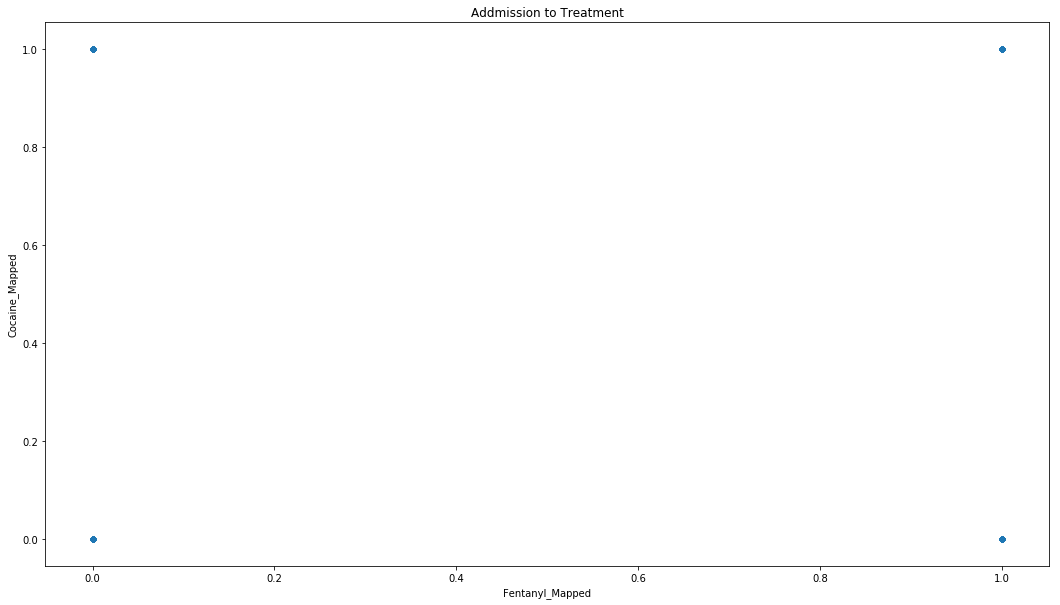

In [54]:
df.plot(kind ='scatter',x = 'Fentanyl_Mapped', y='Cocaine_Mapped' ,figsize=(18, 10),title="Addmission to Treatment")

### Resample on day with a rolloing window of 365

(0, 1082.7)

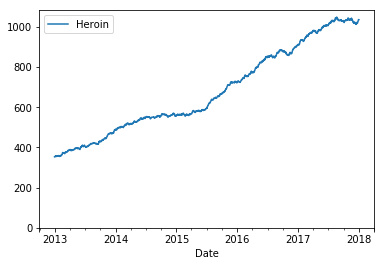

In [55]:
ax =df.resample('D',on='Date').agg({'Heroin':'count'}).rolling(365).sum().plot()
ax.set_ylim(0,None)
df.resample('D',on='Date').agg({'Fentanyl':'count'}).rolling(365).sum().plot()
ax.set_ylim(0,None)

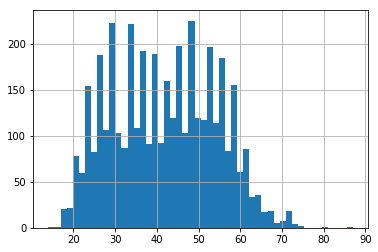

In [56]:
df['Age'].hist(bins = 50)
df['Age'].fillna(df['Age'].median(), inplace = True)

count    4081.000000
mean       41.761333
std        12.317765
min        14.000000
25%        31.000000
50%        42.000000
75%        52.000000
max        87.000000
Name: Age, dtype: float64

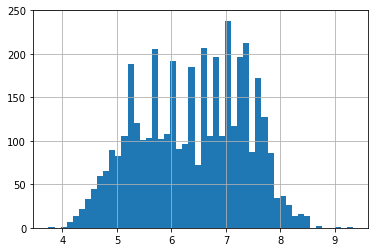

In [57]:

sqrt_transformation = df['Age'].apply(np.sqrt)
sqrt_transformation.hist(bins = 50)
df['Age'].describe()

In [58]:
df.groupby('Sex').agg({'Sex':'count'})

Sex
Sex         
Female  1086
Male    2991

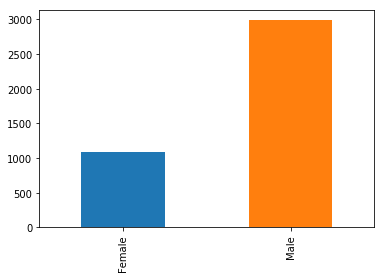

In [59]:
df["Sex"].value_counts().sort_index().plot.bar(y='gender', subplots=False, figsize=(6, 4))

http://www.bigendiandata.com/2017-06-27-Mapping_in_Jupyter/

In [60]:
df.resample('A', on = 'Date').agg({"Date":'count'}).plot(kind='bar')

(0, 130.8)

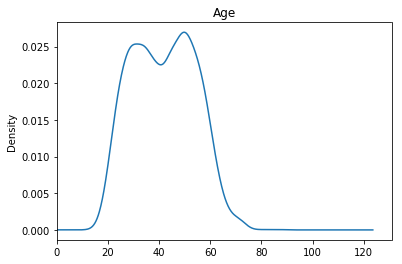

In [61]:
df["Age"].plot.density(title="Age")
plt.xlim(xmin = 0)



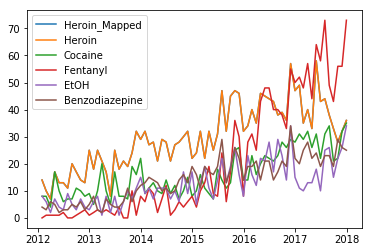

In [62]:
dfYears.groupby(dfYears.index.date).sum().plot()

In [63]:
# start = datetime.date(datetime(2012,1,1))
# end = datetime.date(datetime(2012,12,31))

dfYears.resample('M').truncate(before = '2012-1-1', after= '2013-12-31').plot()


### Scatter Plotting Years vs Drug

In [64]:
year2012 =dfYears.resample('M').truncate(before = '2014-1-1', after= '2018-12-31')
drugList = [              
'Cocaine',              
'Fentanyl',               
'Oxycodone',                 
# 'Oxymorphone',               
# 'EtOH',                     
# 'Hydrocodone',              
# 'Benzodiazepine',           
# 'Methadone',                 
# 'Amphet',                    
# 'Tramad'
]


#https://matplotlib.org/api/pyplot_api.html?highlight=plot_date#matplotlib.pyplot.plot_date

plt.plot_date(year2012.index, year2012['Fentanyl'])
plt.xticks(rotation=70)

(array([735234., 735415., 735599., 735780., 735964., 736146., 736330.,
        736511., 736695.]), <a list of 9 Text xticklabel objects>)